In [8]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

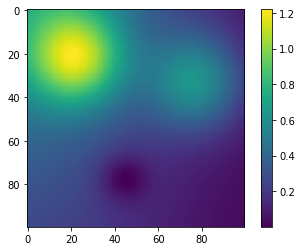

In [12]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.0
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

plt.imshow(frank)
plt.colorbar()
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,8)
#design=np.delete(design, [0,1], axis=1)


#splitting in train and test
xtrain,xtest,ytrain,ytest = train_test_split(design,frank, test_size=0.20, shuffle=True)
# Splitting in train and validation
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain, test_size=0.125, shuffle=True)

#xtrain = design
#xval = design
#xtest = design

#ytrain = frank
#yval = frank
#ytest = frank


In [10]:
epochs=1000
batch_size=1000
n_features=design.shape[1]
etavec = np.logspace(-2, -1, 2)
lmbvec = np.logspace(-7, 0, 8)

activation = [lrf.sigmoid, lrf.sigmoid, lrf.nooutact]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.nooutact]

saved_net = np.zeros((len(etavec), len(lmbvec)), dtype=object)
train_accuracy = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        neural_net = nn.ANN(lmb=lmb, bias=0.5, eta=etas,early_stop_tol = 10e-04,\
                            early_stop_nochange=10, mode= 'regression')            
        neural_net.add_layers(n_features=[n_features,50,20], n_neurons = [50,20,1] , n_layers=3)

        
        neural_net.train(epochs, batch_size, xtrain , ytrain ,activation,derivative,\
                         xval, yval, verbose=False)
        pred = neural_net.feed_out(xtest, activation)
        train_accuracy[i,j] =  fx.MSE(ytest,pred)
        print('training mse for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', train_accuracy [i,j])


KeyboardInterrupt: 

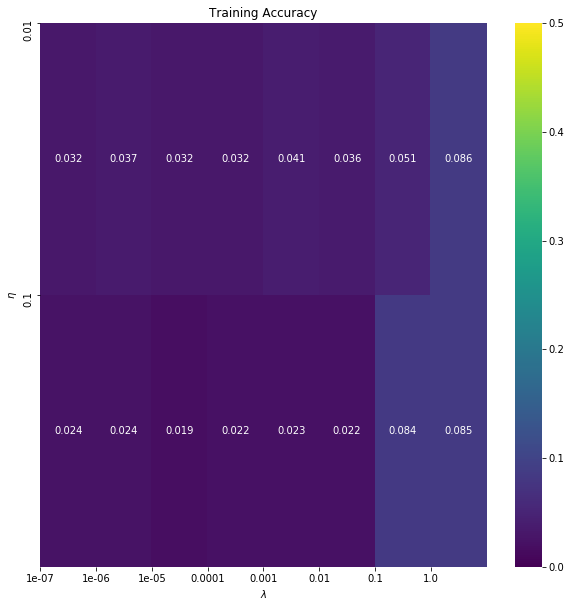

In [40]:
train_accuracy[np.isnan(train_accuracy)]=2

yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels, vmin = 0, vmax=0.5)
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_yticks(range(len(etavec)))
ax.set_xticks(range(len(lmbvec)))
plt.show()

In [41]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.min(train_accuracy))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 

In [83]:
neural_net = nn.ANN(lmb=0, bias=0.5, eta=best_eta,early_stop_tol = 10e-04,\
                            early_stop_nochange=10000, mode= 'regression')            
neural_net.add_layers(n_features=[n_features,50,20], n_neurons = [50,20,1] , n_layers=3)
activation = [lrf.relu, lrf.sigmoid, lrf.relu]
derivative = [lrf.relu_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]
epochs = 20000
neural_net.train(epochs, batch_size, xtrain , ytrain ,activation,derivative, xval, yval, verbose=False)


pred = neural_net.feed_out(xtrain, activation)
train_error = fx.R2Score(ytrain,pred)
train_mse = fx.MSE(ytrain,pred)
pred = neural_net.feed_out(xval, activation)
validation_error = fx.R2Score(yval,pred)
validation_mse = fx.MSE(yval,pred)
pred = neural_net.feed_out(xtest, activation)
test_error = fx.R2Score(ytest,pred)
test_mse = fx.MSE(ytest,pred)

print('training R2',  train_error, 'and MSE=', train_mse )
print('validation R2',  validation_error, 'and MSE=', validation_mse )
print('training R2',  test_error, 'and MSE=', test_mse )

training R2 0.5719896657927953 and MSE= 0.06168237268545265
validation R2 0.5416187070508653 and MSE= 0.06194741939626445
training R2 0.5527157315996301 and MSE= 0.0649471087187365


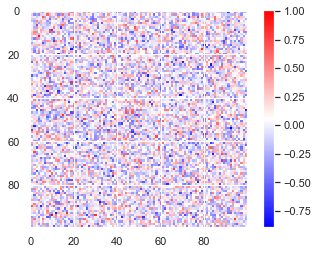

0.565288991093235


In [85]:
pred = neural_net.feed_out(design, activation)

#plt.subplot(1, 2, 1)
plt.imshow(pred.reshape([n,n])- frank.reshape([n,n]), cmap='bwr')
#plt.subtitle('Predicted')
#plt.subplot(1, 2, 2)
#plt.subtitle('Franke')
#plt.imshow(frank.reshape([n,n]))
plt.colorbar()
plt.show()





print(fx.R2Score(frank.ravel(),pred.ravel()))

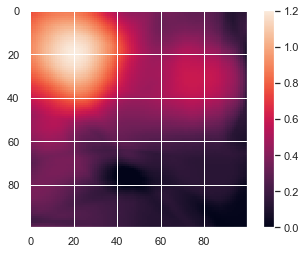

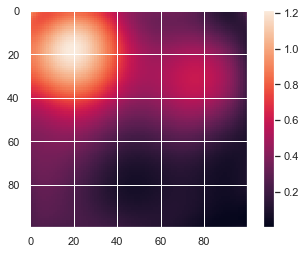

0.5555807980346987

In [86]:
pred = neural_net.feed_out(design, activation)



plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

beta, pred = fx.OridinaryLeastSquares(design, frank, design)



plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

fx.R2Score(yval,xval@beta)



0.9883943208697513
0.9757113345184922
0.9704380909796627
0.9293344160452393
0.80894687711973
0.5044100185251212
-0.005269624501290426
0.9948616261750548
0.9939726112090008
0.9819664930689785
0.9309726060948544
0.7904310447650696
0.5258615082062392
-0.002229556401229127


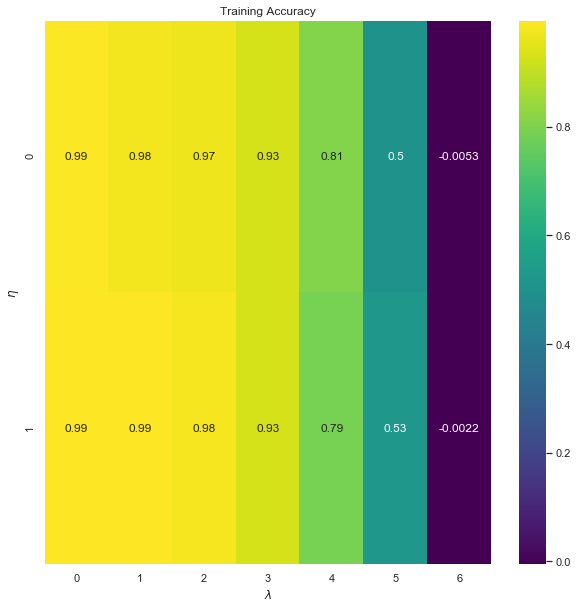

In [46]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (50,20)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [11]:
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)


etamax=eta_vals[1]
lmbmax=lmbd_vals[0]

dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbmax, learning_rate_init=etamax, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

NameError: name 'n_hidden_neurons' is not defined

In [5]:
pred = dnn.predict(X_train)


plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

print(fx.R2Score(pred,frank.ravel()))

NameError: name 'dnn' is not defined